In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import deepmatcher as dm
import torch
from deepmatcher.data import MatchingIterator
from torch.autograd import Variable
import pandas as pd

In [4]:
walmartamazon_hybrid = dm.MatchingModel(attr_summarizer='hybrid')
walmartamazon_hybrid.load_state('../../models/walmartamazon_hybrid_nonull.pth')

In [5]:
from utilities_functions.intermediate_layer_extraction import return_layer_input

In [6]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Walmart-Amazon/','test_negatives',
                                                  batch_size=128,model=walmartamazon_hybrid,
                                                   layer=walmartamazon_hybrid.classifier,
                                                  device=-1)

In [7]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Walmart-Amazon/','test_positives',
                                                  batch_size=128,model=walmartamazon_hybrid,
                                                  layer=walmartamazon_hybrid.classifier,
                                                  device=-1)

In [8]:
walmartamazon_hybrid = walmartamazon_hybrid.cuda()

## Ri discovery

### Negative samples analysis

In [9]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change
from tqdm import tqdm

In [10]:
attributes =['title','category','brand','modelno','price']

In [16]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in neg_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change(walmartamazon_hybrid.classifier,
                                                             classifier_length= 900,
                                                             attribute_length= 180,input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],
                                                          class_to_reach=1,learning_rate=1)
            current_sample_ris.append(variation)
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

 34%|███▍      | 44/128 [00:17<00:34,  2.45it/s]

KeyboardInterrupt: 

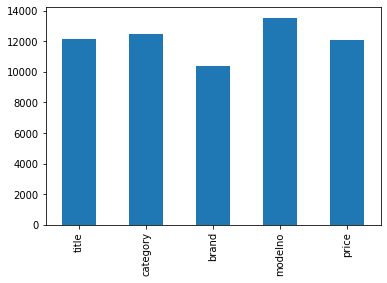

In [13]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
ri_sums = negatives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

In [ ]:
negatives_variation_df.to_csv('experiment_results/testnegatives_ri_v2.csv',index=False)

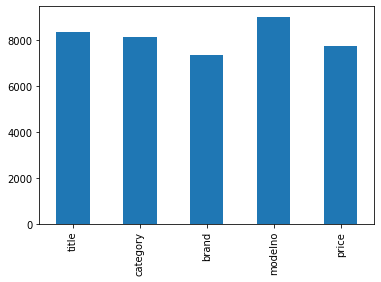

In [14]:
x = pd.read_csv('experiment_results/testnegatives_ri_v2.csv')
x.sum().plot.bar()

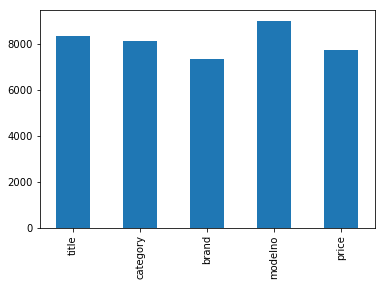

In [12]:
import pandas as pd
negatives_df = pd.read_csv('experiment_results/testnegatives_ri_v2.csv')
negatives_df.sum().plot.bar()

### Positive samples analysis

In [13]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri = []
for batch in pos_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change(walmartamazon_hybrid.classifier,
                                                             classifier_length= 900,
                                                             attribute_length= 180,input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],class_to_reach=0
                                                         ,learning_rate=1)
            current_sample_ris.append(variation)
        positives_ri.append(current_sample_ris)
        current_sample+=1

 14%|█▍        | 18/128 [02:20<13:29,  7.36s/it]

 Gradient is null
 Gradient is null


100%|██████████| 65/65 [03:14<00:00,  3.00s/it]


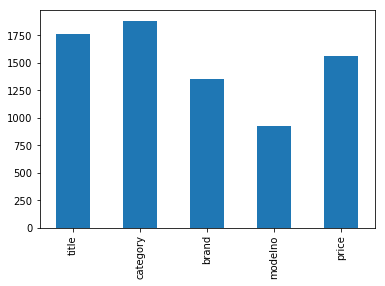

In [14]:
ri_norms_positives = []
for ri_list in positives_ri:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
positives_variation_df.sum(numeric_only=True).plot.bar()

In [15]:
positives_variation_df.to_csv('experiment_results/testpositives_ri_v2.csv',index=False)